In [1]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import sys

sys.path.append('../')
from util.preprocessing_utils import standardize_column

In [2]:
df = pd.read_csv('../data/processed/ProcessedTweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negative_reason,negative_reason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,fractional_hour,hour_sin,hour_cos
0,570306133677760513,0,1.0000,0,0.0000,0,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52-08:00,Unknown,Eastern Time (US & Canada),11.597778,0.105107,-0.994461
1,570301130888122368,1,0.3486,0,0.0000,0,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59-08:00,Unknown,Pacific Time (US & Canada),11.266389,0.190880,-0.981613
2,570301083672813571,0,0.6837,0,0.0000,0,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada),11.263333,0.191666,-0.981460
3,570301031407624196,2,1.0000,1,0.7033,0,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36-08:00,Unknown,Pacific Time (US & Canada),11.260000,0.192522,-0.981293
4,570300817074462722,2,1.0000,2,1.0000,0,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45-08:00,Unknown,Pacific Time (US & Canada),11.245833,0.196160,-0.980572


In [24]:
df.describe()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negative_reason,negative_reason_confidence,airline,retweet_count,fractional_hour,hour_sin,hour_cos
count,1.464000e+04,14640.000000,1.464000e+04,14640.000000,14640.000000,14640.000000,14640.000000,14640.000000,14640.000000,14640.000000
mean,5.692184e+17,1.415232,2.950888e-16,2.675751,0.458755,2.785178,0.082650,12.817539,-0.066026,-0.316231
std,7.791112e+14,0.816223,1.000000e+00,2.651616,0.401057,1.557632,0.745778,5.302708,0.719609,0.614705
min,5.675883e+17,0.000000,-3.470914e+00,0.000000,0.000000,0.000000,0.000000,0.002500,-1.000000,-1.000000
25%,5.685592e+17,1.000000,-1.276601e+00,0.000000,0.000000,1.000000,0.000000,8.850833,-0.784686,-0.867232
50%,5.694779e+17,2.000000,6.131006e-01,3.000000,0.624600,3.000000,0.000000,12.679861,-0.147162,-0.500787
75%,5.698905e+17,2.000000,6.131006e-01,4.000000,0.703300,4.000000,0.000000,17.061528,0.666004,0.162501
max,5.703106e+17,2.000000,6.131006e-01,10.000000,1.000000,5.000000,44.000000,23.985556,1.000000,1.000000


In [3]:
df = standardize_column(df, 'airline_sentiment_confidence')

The model below is working somewhat, let's use this and build around it. Be pragmatic.

In [28]:
with pm.Model() as model:
    alpha = pm.Normal('Intercept', mu=0, sigma=10)
    airline_coeff = pm.Normal('airline_coeff', mu=0, sigma=10, shape=len(df['airline'].unique()))
    conf_coeff = pm.Normal('conf_coeff', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)
    sent_coeff = pm.Normal('sent_coeff', mu=0, sigma=10)

    airline_index = df['airline'].astype(int)

    mu = (alpha + 
          airline_coeff[airline_index] + 
          conf_coeff * df['airline_sentiment_confidence'])

    sentiment_obs = pm.Normal('sentiment_obs', mu=mu, sigma=sigma, observed=df['airline_sentiment'])

    nuts_sampler_kwargs = {'target_accept': 0.95, 'max_treedepth': 20}
    trace = pm.sample(1000, tune=1000, nuts_sampler_kwargs=nuts_sampler_kwargs, return_inferencedata=True)

az.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, airline_coeff, conf_coeff, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 433 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.655,3.994,-7.203,7.889,0.321,0.227,156.0,225.0,1.03
airline_coeff[0],0.395,3.995,-6.846,8.263,0.321,0.227,156.0,227.0,1.03
airline_coeff[1],0.851,3.994,-6.376,8.709,0.321,0.227,156.0,225.0,1.03
airline_coeff[2],0.578,3.994,-6.687,8.406,0.321,0.227,156.0,225.0,1.03
airline_coeff[3],0.488,3.994,-6.745,8.340,0.321,0.227,156.0,225.0,1.03
airline_coeff[4],0.963,3.994,-6.277,8.820,0.321,0.227,156.0,225.0,1.03
airline_coeff[5],0.865,3.994,-6.365,8.742,0.321,0.227,156.0,225.0,1.03
conf_coeff,0.208,0.006,0.197,0.221,0.000,0.000,992.0,1163.0,1.00
sigma,0.762,0.004,0.754,0.771,0.000,0.000,818.0,1144.0,1.00


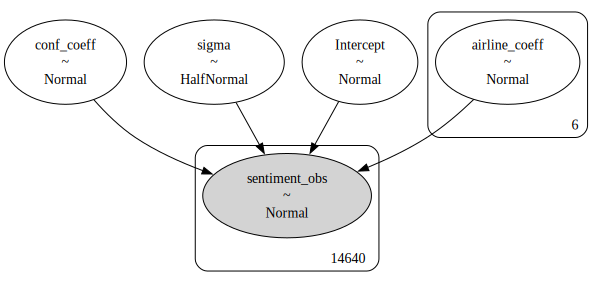

In [29]:
pm.model_to_graphviz(model)

In [31]:
import pymc as pm
import arviz as az
import pandas as pd

with pm.Model() as model:
    alpha = pm.Normal('Intercept', mu=0, sigma=10)
    airline_coeff = pm.Normal('airline_coeff', mu=0, sigma=10, shape=len(df['airline'].unique()))
    sentiment_coeff = pm.Normal('sentiment_coeff', mu=0, sigma=10, shape=len(df['airline_sentiment'].unique()))
    sine_coeff = pm.Normal('sine_coeff', mu=0, sigma=10)
    cosine_coeff = pm.Normal('cosine_coeff', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    airline_index = df['airline'].astype(int)
    sentiment_index = df['airline_sentiment'].astype(int)

    mu = (alpha +
          airline_coeff[airline_index] +
          sentiment_coeff[sentiment_index] +
          sine_coeff * df['hour_sin'] +
          cosine_coeff * df['hour_cos'])

    confidence_obs = pm.Normal('confidence_obs', mu=mu, sigma=sigma, observed=df['airline_sentiment_confidence'])

    nuts_sampler_kwargs = {'target_accept': 0.98, 'max_treedepth': 12}
    trace = pm.sample(1000, tune=1000, nuts_sampler_kwargs=nuts_sampler_kwargs, return_inferencedata=True)

az.summary(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, airline_coeff, sentiment_coeff, sine_coeff, cosine_coeff, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1069 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.510,5.441,-9.502,10.818,0.477,0.338,137.0,217.0,1.04
airline_coeff[0],0.055,3.504,-5.967,7.338,0.394,0.279,80.0,151.0,1.06
airline_coeff[1],0.037,3.504,-6.022,7.272,0.393,0.279,80.0,157.0,1.06
airline_coeff[2],0.053,3.503,-6.052,7.272,0.393,0.279,80.0,150.0,1.06
airline_coeff[3],-0.014,3.503,-6.075,7.238,0.393,0.279,80.0,152.0,1.06
airline_coeff[4],0.120,3.503,-5.928,7.402,0.393,0.279,80.0,153.0,1.06
airline_coeff[5],0.127,3.503,-5.942,7.361,0.393,0.279,80.0,156.0,1.06
sentiment_coeff[0],-1.026,5.043,-10.011,8.410,0.549,0.389,87.0,416.0,1.05
sentiment_coeff[1],-0.725,5.043,-9.741,8.703,0.549,0.389,87.0,416.0,1.05
sentiment_coeff[2],-0.373,5.043,-9.384,9.062,0.548,0.389,87.0,416.0,1.05


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'airline_coeff'}>,
        <Axes: title={'center': 'airline_coeff'}>],
       [<Axes: title={'center': 'sentiment_coeff'}>,
        <Axes: title={'center': 'sentiment_coeff'}>],
       [<Axes: title={'center': 'sine_coeff'}>,
        <Axes: title={'center': 'sine_coeff'}>],
       [<Axes: title={'center': 'cosine_coeff'}>,
        <Axes: title={'center': 'cosine_coeff'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

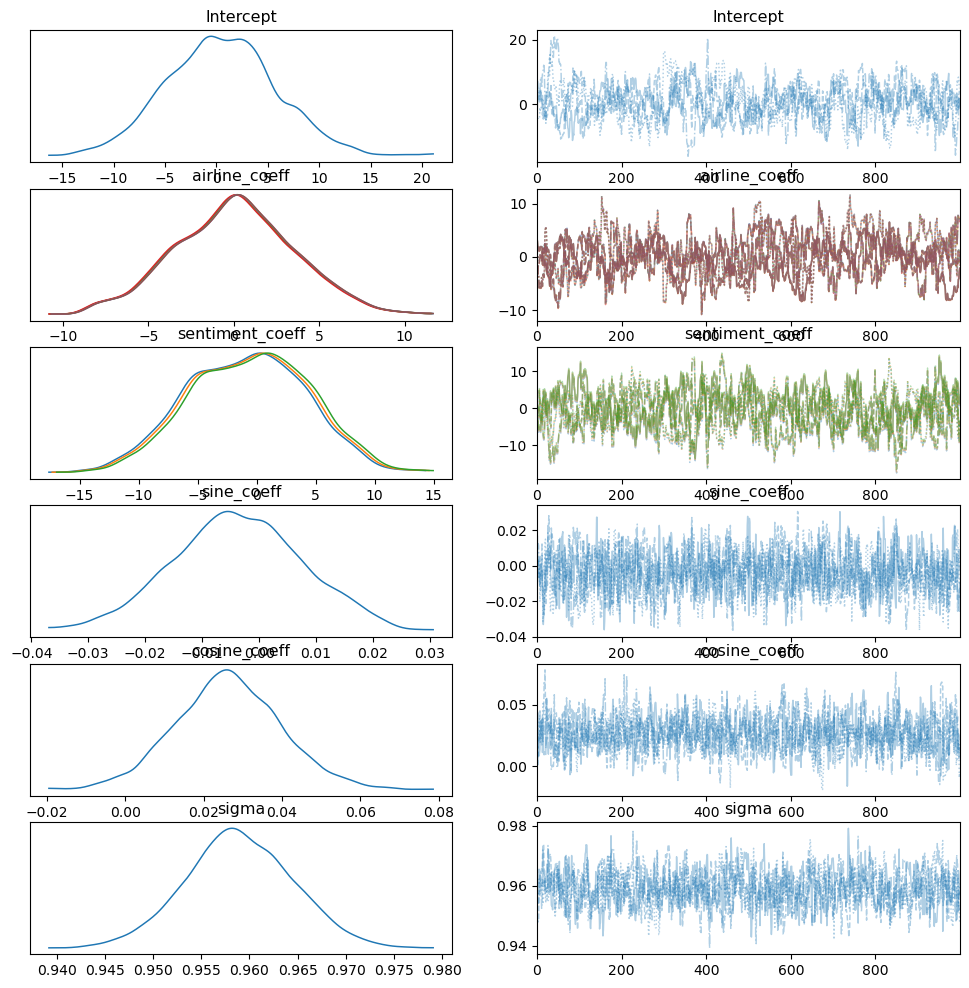

In [32]:
az.plot_trace(trace, combined=True)